In [4]:
# dark theme extension https://stackoverflow.com/questions/46510192/change-the-theme-in-jupyter-notebook
import fingertips_py as ftp
import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None)
import os
pd.set_option('display.max_colwidth', -1)    # stop the column text truncating... 
pd.set_option("display.max_rows", None, "display.max_columns", None)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Summary 

* We can safely say that for our NHS CCGs of interest, there are no NaN/0/Surpressed values for the 'Value' fields across all indicators for hospital admissions. There are also no outliers recorded. 
* The "Admissions for lower respiratory tract infections in infants aged 1 year" indicator contained two null (annual) points for a the Surry Heath CCG. As this indicator has less data points than all other indicators, and there is a similar indicator that has more coverage, the team will consider omitting this indicator from our analysis. 


## Load in the Data

In [5]:
### Hospital admission datasets - indicator IDs were sourced from the Fingertips metadata files. 

# concat indicator data, output as a CSV file
def _concat_output_data(indicator_ids, name):
    directory = './data_output/{0}'.format(name)

    if not os.path.exists(directory):
        os.makedirs(directory)
        
    lst_df = []
    for ids in indicator_ids:
        print('processing for id: ', ids)
        tmp_d = ftp.get_data_for_indicator_at_all_available_geographies(ids)
        lst_df.append(tmp_d)
        
    tmp_concat = pd.concat(lst_df, axis=0, ignore_index=True)
    
    tmp_concat.to_csv(directory + '/' +  name + '.csv')
    
    # free memory
    tmp_concat= None 
    lst_df = None


We will concetenate our hospital admissions datasources using the fingertips_py python wrapper. The "_concat_output_data" function takes a list of health indictors ID, which the team sourced from the metadata files for respioratory and cardiovascular diseases on https://fingertips.phe.org.uk/, and returns a single dataset which is saved to CSV for future reference. 

In [6]:
# navigate through API for hospital indicators and concat the hospital_admissions dataset, commented out as we have already completed
# save concatenated set to CSV
# _concat_output_data([92302,93577, 93575, 92253, 92971, 92252, 92251, 92970, 93573, 90810, 92780, 93574, 90988, 90987, 91468, 91462], 'hospital_admissions_resp_crdv')

# Preliminary Analysis on Admissions Dataset

In [7]:
# some basic checks 

def preliminary_data_checks(df, name):
    
    print('Running analysis checks on the {0} DataFrame...'.format(name))
    print('\n\n')
    
    print('the shape of the df is as follows: ', df.shape)
    print('\n\n')

    print('Check 1. Columns for the {0} DataFrame as as follows: {1} \n'.format(name, list(df.columns)))
    print('\n\n')

    print('Check 2. The {0} DataFrame column datatypes are as follows: {1}'.format(name, df.dtypes))
    print('\n\n')
    
    print('Check 1a. NULL values in Columns for the {0} DataFrame as as follows: \n'.format(name))
    print(df.isna().sum())
    print('\n\n')
    
    indicators = df['Indicator Name'].unique()
    print('there are {0} diifferent indicators in this set, they are as follows:'.format(len(indicators)))
    for indicator in indicators:
        print(indicator)
        
    print('\n\n')
    
    print('data is prevalent for the following years (individual indicator analysis is required...) \n')
    print(sorted(df['Time period Sortable'].unique()))


In [8]:
# load in the concatenated dataset from CSV, (output directory from _concat_output_data() function). Also fix year col
admissions_crdv_resp = pd.read_csv('./data_output/hospital_admissions_resp_crdv/hospital_admissions_resp_crdv.csv')
admissions_crdv_resp['Time period Sortable'] =  pd.to_datetime(
    (admissions_crdv_resp['Time period Sortable']/10000).astype(int), 
    format='%Y').dt.year

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
# Run some prelimininary checks
preliminary_data_checks(admissions_crdv_resp, 'hospital_admissions_resp_crdv.csv')

Running analysis checks on the hospital_admissions_resp_crdv.csv DataFrame...



the shape of the df is as follows:  (99544, 27)



Check 1. Columns for the hospital_admissions_resp_crdv.csv DataFrame as as follows: ['Unnamed: 0', 'Indicator ID', 'Indicator Name', 'Parent Code', 'Parent Name', 'Area Code', 'Area Name', 'Area Type', 'Sex', 'Age', 'Category Type', 'Category', 'Time period', 'Value', 'Lower CI 95.0 limit', 'Upper CI 95.0 limit', 'Lower CI 99.8 limit', 'Upper CI 99.8 limit', 'Count', 'Denominator', 'Value note', 'Recent Trend', 'Compared to England value or percentiles', 'Compared to percentiles', 'Time period Sortable', 'New data', 'Compared to goal'] 




Check 2. The hospital_admissions_resp_crdv.csv DataFrame column datatypes are as follows: Unnamed: 0                                  int64  
Indicator ID                                int64  
Indicator Name                              object 
Parent Code                                 object 
Parent Name            

In [10]:
admissions_crdv_resp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99544 entries, 0 to 99543
Data columns (total 27 columns):
Unnamed: 0                                  99544 non-null int64
Indicator ID                                99544 non-null int64
Indicator Name                              99544 non-null object
Parent Code                                 97825 non-null object
Parent Name                                 97825 non-null object
Area Code                                   99544 non-null object
Area Name                                   99544 non-null object
Area Type                                   99544 non-null object
Sex                                         99544 non-null object
Age                                         99544 non-null object
Category Type                               2968 non-null object
Category                                    2968 non-null object
Time period                                 99544 non-null object
Value                                

## Restrict the Dataframe to CCGs/Areas in the DS4A Project Scope

In [11]:
admissions_crdv_resp['Indicator Name'].unique()

array(['Emergency hospital admissions for COPD',
       'Emergency hospital admissions for COPD, all ages',
       'Emergency hospital admissions for respiratory disease',
       'Admissions for lower respiratory tract infections in children aged 2, 3 and 4 years',
       'Admissions for lower respiratory tract infections in infants aged 1 year',
       'Admissions for lower respiratory tract infections in infants aged under 1 year',
       'Emergency hospital admissions for asthma in adults (aged 19 years and over)',
       'Hospital admissions for asthma (under 19 years)',
       'Emergency hospital admissions for pneumonia',
       'CHD admissions (all ages)', 'Heart failure admissions (all ages)',
       'Stroke admissions (Sentinel Stroke National Audit Programme)',
       'Stroke admissions with history of atrial fibrillation not prescribed anticoagulation prior to stroke'], dtype=object)

### Question: Which Area Types Should the Team use?

CCG is recommended/the most granular.
hospital admissions on CCG are available, because the dataset joins a dataset from the NHS Hospital Emission Statistics (HES) data warehouse with GP information, therefore hospital emissions are linked to GP CCG areas via paitent registration. 

In [12]:
for indicator in sorted(admissions_crdv_resp['Indicator Name'].unique()): 
    print('distince types for admission {0} are as follows: \n\n'.format(indicator))
    print(admissions_crdv_resp['Area Type'].unique())
    print('\n\n')

distince types for admission Admissions for lower respiratory tract infections in children aged 2, 3 and 4 years are as follows: 


['England' 'County & UA (4/19-3/20)' 'District & UA (4/19-3/20)'
 'Combined authorities' 'County & UA (pre 4/19)' 'District & UA (pre 4/19)'
 'Region' 'CCGs (since 4/20)' 'CCGs (2019/20)' 'STP (since 4/20)'
 'STP (pre 4/20)' 'CCGs (2018/19)' 'CCGs (2017/18)']



distince types for admission Admissions for lower respiratory tract infections in infants aged 1 year are as follows: 


['England' 'County & UA (4/19-3/20)' 'District & UA (4/19-3/20)'
 'Combined authorities' 'County & UA (pre 4/19)' 'District & UA (pre 4/19)'
 'Region' 'CCGs (since 4/20)' 'CCGs (2019/20)' 'STP (since 4/20)'
 'STP (pre 4/20)' 'CCGs (2018/19)' 'CCGs (2017/18)']



distince types for admission Admissions for lower respiratory tract infections in infants aged under 1 year are as follows: 


['England' 'County & UA (4/19-3/20)' 'District & UA (4/19-3/20)'
 'Combined authorities' 'Coun

In [13]:
# limit the DF to CCG types only (latest classification)
ccg_df = admissions_crdv_resp[admissions_crdv_resp['Area Type'] == 'CCGs (2019/20)']

## Data Information

Fields of Interest:
* Value - Standardised ratio of indicator / 100,000 population datasets.
* Count - Granular sum of residents admitted on a yearly cadence in a particular area type (i.e. In the hillingdon CCG 560 residents were admitted to hospital with Asthma in 2014 )
* Denominator - the number of residents registered in the Hillingdon.
* Time period Sortable - date (year) indicator 
* Area Name - Field name for CCG, e.g. 'NHS Hillingdon CCG'

Background:
This dataset joins on the NHS Hospital Episode Statistic warehouse and GP datasets, paitents emmitted to hospital have their paitent ID logged, which corresponds to their registered GP. Hence, this is why the indicator numbers are on CCG level (given cluster of GPs in area).

We will now invesrtigate whether to use Value (standardised ratio), or infer our own calculated metric from the count and denominator (depending on which fields are null.

## How Many NaNs are present?

In [14]:
admissions_crdv_resp.isna().sum()

Unnamed: 0                                  0    
Indicator ID                                0    
Indicator Name                              0    
Parent Code                                 1719 
Parent Name                                 1719 
Area Code                                   0    
Area Name                                   0    
Area Type                                   0    
Sex                                         0    
Age                                         0    
Category Type                               96576
Category                                    96576
Time period                                 0    
Value                                       1658 
Lower CI 95.0 limit                         6736 
Upper CI 95.0 limit                         6736 
Lower CI 99.8 limit                         56319
Upper CI 99.8 limit                         56319
Count                                       4092 
Denominator                                 2974 


From first impressions, there are a very small number of NaN values in our fields of interest (Count ~ 4k, Denominator ~ 3k, value ~ 2k). However, further investigation will be required to check whether indicator information is surpressed in our CCGs/Areas of interest as zeros.


In [15]:
admissions_crdv_resp[admissions_crdv_resp['Count'].isna()].head(2)

,Unnamed: 0,Indicator ID,Indicator Name,Parent Code,Parent Name,Area Code,Area Name,Area Type,Sex,Age,Category Type,Category,Time period,Value,Lower CI 95.0 limit,Upper CI 95.0 limit,Lower CI 99.8 limit,Upper CI 99.8 limit,Count,Denominator,Value note,Recent Trend,Compared to England value or percentiles,Compared to percentiles,Time period Sortable,New data,Compared to goal
175,175,92302,Emergency hospital admissions for COPD,E92000001,England,E06000053,Isles of Scilly,County & UA (4/19-3/20),Male,35+ yrs,NaN,NaN,2010/11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Value for Cornwall and Isles of Scilly combined,NaN,Not compared,Not compared,2010,NaN,NaN
216,216,92302,Emergency hospital admissions for COPD,E92000001,England,E09000001,City of London,County & UA (4/19-3/20),Male,35+ yrs,NaN,NaN,2010/11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Value for Hackney and City of London combined,NaN,Not compared,Not compared,2010,NaN,NaN


In [16]:
for value in (admissions_crdv_resp[admissions_crdv_resp['Count'].isna()]['Value note'].unique()):
    print(value)


Value for Cornwall and Isles of Scilly combined
Value for Hackney and City of London combined
Value is not presented due to an issue with HES coding in Nottingham University Hospitals Trust in 2016/17, for which over 30% of records did not have a valid geography of residence assigned. In 2015/16, over 20% of patients that attended hospital from this area were treated at Nottingham University Hospitals Trust.
Value is not presented due to an issue with HES coding in East Sussex Healthcare NHS Trust in 2018/19, for which approximately 85,000 records erroneously had all diagnosis codes removed. In 2018/19, over 10% of patients that attended hospital from this area had records that were missing diagnosis codes
Value suppressed for disclosure control reasons
Value suppressed for disclosure control due to small count
Value suppressed to avoid disclosure by differencing
Due to an issue with HES coding in Nottingham University Hospitals Trust in 2016/17, for which over 30% of records did not h

The NaNs/null 'Count' values have a corresponding explanation in the 'Value note column'. We can see that some  counts are supressed in areas so we will zoom in on our CCG areas of interest to see if any action is required.

In [17]:
# as the value for our fields of interest are all floats, we should check for 0s and NaN values
print(admissions_crdv_resp['Count'].dtype)
print(admissions_crdv_resp['Denominator'].dtype)
print(admissions_crdv_resp['Value'].dtype)

float64
float64
float64


## Check NaNs in CCGs of Interest

In [18]:
# https://www.healthysurrey.org.uk/__data/assets/image/0003/137901/CCG-location-map-large.jpg

# A way, to search the 'Area Name' field to with values like 'hillingdon', to return the CCG name, 'NHS HILLINGDON CCG'
# ccg_indicator_interest = h[h['Area Name'].str.lower().str.contains('|'.join([x.lower() for x in outer_ccg_to_retain]))]

inner_ccgs = ['NHS Buckinghamshire CCG', 'NHS Ealing CCG', 'NHS East Berkshire CCG', 'NHS Hillingdon CCG',
 'NHS Hounslow CCG', 'NHS North West Surrey CCG']

outer_ccgs =  ['NHS Basildon And Brentwood CCG', 'NHS Berkshire West CCG', 'NHS Brent CCG', 'NHS Croydon CCG',
               'NHS Guildford and Waverley CCG', 'NHS Hammersmith And Fulham CCG', 'NHS Harrow CCG', 
               'NHS Herts Valleys CCG', 'NHS Kingston CCG', 'NHS Merton CCG', 'NHS Oxfordshire CCG', 
               'NHS Richmond CCG', 'NHS Surrey Heath CCG', 'NHS Sutton CCG', 'NHS Wandsworth CCG']

ccg_indicator_interest = ccg_df[ccg_df['Area Name'].isin(inner_ccgs + outer_ccgs)]


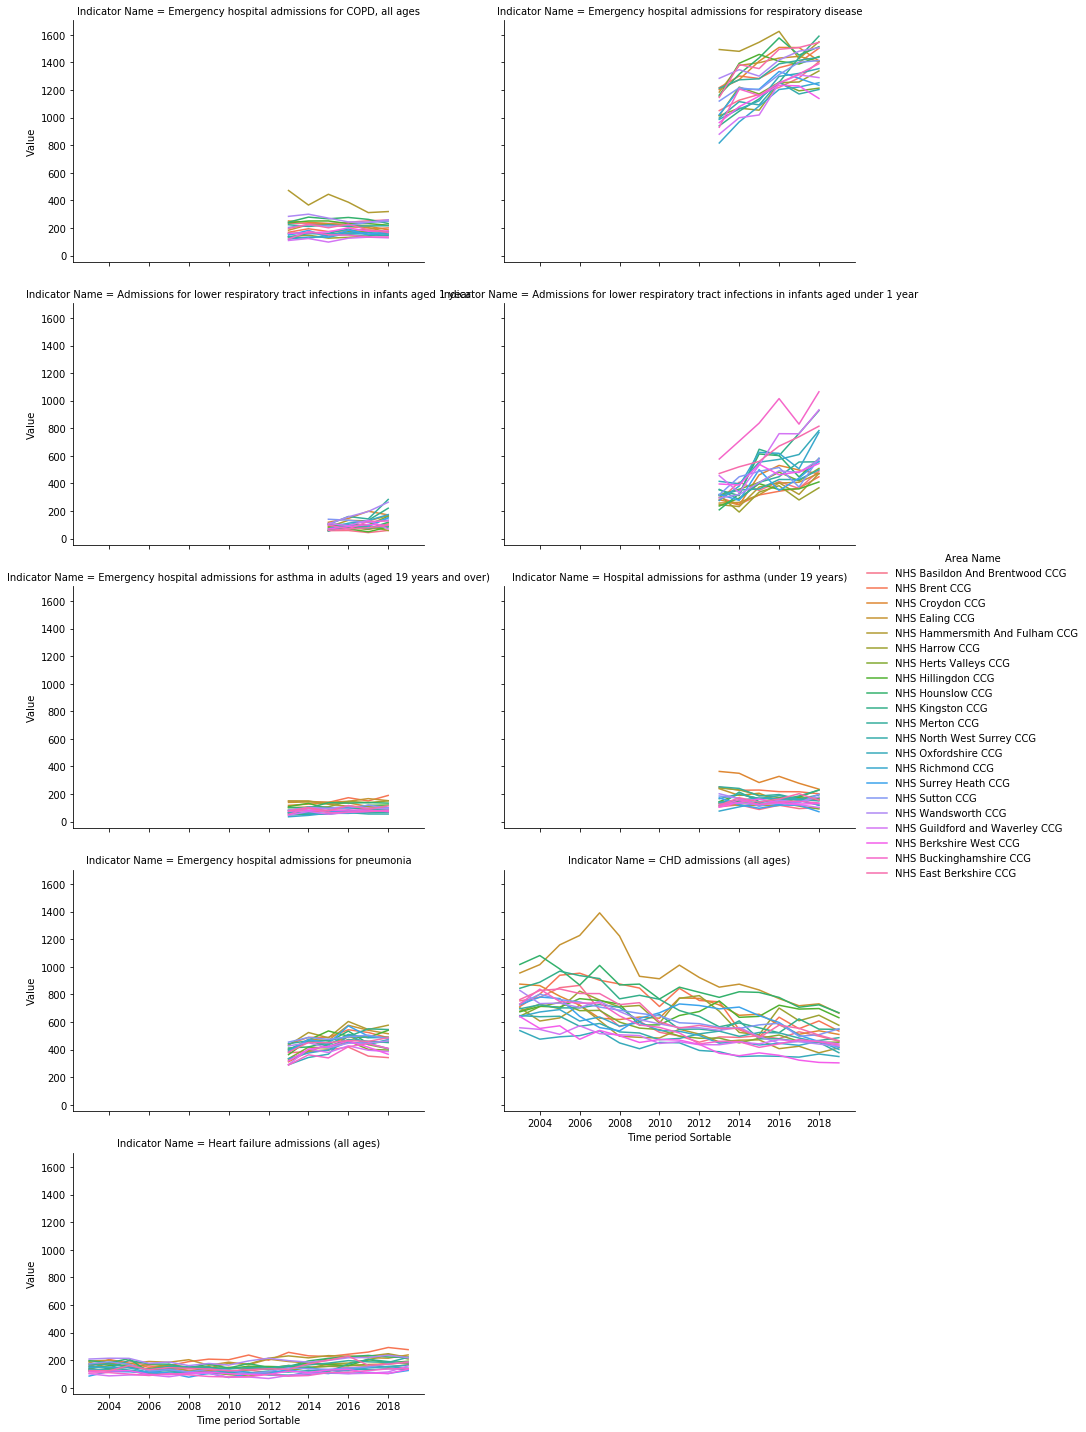

In [19]:
# first facet, restrict to person rows only, so we can get an overall picture
first = ccg_indicator_interest[ccg_indicator_interest['Sex']== 'Persons'][['Indicator Name', 'Area Name', 'Time period Sortable', 'Value']]
first.head(10)
g = sns.FacetGrid(first, col='Indicator Name', hue='Area Name', col_wrap=2,height=4, aspect=1.5)
g.map(sns.lineplot, 'Time period Sortable', 'Value')
g.add_legend()


In [20]:
print('The only NaN values are recorded for the "Admissions for lower respiratory tract infections in infants aged 1 year" indicator for the Surry Heath CCG. As this indicator has less points than all others, and there is a more interesting indicator marked "Admissions for lower respiratory tract infections in infants aged under 1 year" it is likely the team will omit this indicator\n')

first[first['Value'].isna()]

The only NaN values are recorded for the "Admissions for lower respiratory tract infections in infants aged 1 year" indicator for the Surry Heath CCG. As this indicator has less points than all others, and there is a more interesting indicator marked "Admissions for lower respiratory tract infections in infants aged under 1 year" it is likely the team will omit this indicator



,Indicator Name,Area Name,Time period Sortable,Value
26553,Admissions for lower respiratory tract infections in infants aged 1 year,NHS Surrey Heath CCG,2015,NaN
27132,Admissions for lower respiratory tract infections in infants aged 1 year,NHS Surrey Heath CCG,2016,NaN


As Stroke Indicators did not appear in our FacetGrid, we will double check them with an alternative CCG definition. In addition "Admissions for lower respiratory tract infections in children aged 2, 3 and 4 years" did not appear on our grid because it is only County level and not granular enough for our analysis.

### Checking Stroke Indicators


As Stroke Indicators did not appear in the 2019/2020 CCG definition, we will use an older CCG definition.

In [31]:
# Filter to Stroke admissions, and to CCGs of interest 
strk = admissions_crdv_resp[admissions_crdv_resp['Indicator Name'].isin(['Stroke admissions (Sentinel Stroke National Audit Programme)', 'Stroke admissions with history of atrial fibrillation not prescribed anticoagulation prior to stroke'])]
strk = strk[(strk['Area Type'] == 'CCGs (2018/19)') & (strk['Area Name'].isin(inner_ccgs + outer_ccgs))]


In [29]:
print('there are 0 null entries in the "Value" field for stroke indicators')

strk.isna().sum()

there are 0 null entries in the "Value" field for stroke indicators


Unnamed: 0                                  0  
Indicator ID                                0  
Indicator Name                              0  
Parent Code                                 0  
Parent Name                                 0  
Area Code                                   0  
Area Name                                   0  
Area Type                                   0  
Sex                                         0  
Age                                         0  
Category Type                               204
Category                                    204
Time period                                 0  
Value                                       0  
Lower CI 95.0 limit                         204
Upper CI 95.0 limit                         204
Lower CI 99.8 limit                         204
Upper CI 99.8 limit                         204
Count                                       111
Denominator                                 111
Value note                              

**Thus** we can safely say that for our NHS CCGs of interest, there are no NaN/0/Surpressed values for the 'Value' fields across all indicators. There are also no outliers recorded for the CCGs of interest. 

